In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
- Author(s) : Nima Hosseini Dashtbayaz
- Date: November 14th, 2022
- Title of ource code: Pinns
- Commit SHA: 3ff52aad08cb5315c4037824724240f43b336ab7
- Type: Python
- Repo URL: https://github.com/nimahsn/pinns.git
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from Modules.data import simulate_kdv
from Modules.models import KdvPinn
from Modules.plots import plot_kdv_model, plot_training_loss



2023-05-03 14:20:11.227847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Two-soliton

In [11]:
## execute this cell for two-soliton solution

c1 = 3.23 #3.25 
c2 = 0.5 #0.5

#c1 = 2.5
#c2 = 0.9
print(c1/c2)
phi = 0
def phi_function(tx):
    offset = 0
    ksi1 = tx[:, 1:2] - c1*tx[:, 0:1] + 8
    ksi2 = tx[:, 1:2] - c2*tx[:, 0:1] + offset
    exact = 2*(c1-c2) * (c1*tf.cosh(np.sqrt(c2)*(ksi2)/2)**2 + c2* (tf.sinh(np.sqrt(c1)*(ksi1)/2)**2))/ ((np.sqrt(c1)-np.sqrt(c2)) * tf.cosh((np.sqrt(c1) * ksi1 +np.sqrt(c2)* ksi2)/2) +  (np.sqrt(c1)+np.sqrt(c2)) * tf.cosh((np.sqrt(c1)*ksi1-np.sqrt(c2)*ksi2)/2))**2
    return exact
    
    
def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])

x_start = -40
length = 40
time = 10

6.46


In [19]:
# two soliton superimposed 
c1 = 3.23 
c2 = 0.5 

phi = 0
def phi_function(tx):
    offset = 0
    ksi1 = tx[:, 1:2] - c1*tx[:, 0:1] + 8
    ksi2 = tx[:, 1:2] - c2*tx[:, 0:1] + offset
    #offset = 8
    return c1 / (2*(tf.cosh(np.sqrt(c1)*(ksi1)/2))**2) + c2 / (2*(tf.cosh(np.sqrt(c2)*(ksi2)/2))**2)
    

def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])

x_start = -40
length = 40
time = 10


In [20]:
(tx_eqn, y_eqn), (tx_init, y_init), (tx_boundary, y_boundary) = simulate_kdv(10000, phi_function, boundary_function, length, time, x_start,random_seed = 42, dtype=tf.float32) 
network = KdvPinn.build_network([32, 64, 64, 64, 32]) 
model = KdvPinn(network)
model.compile()



In [27]:
### construct analytical solution for comparison later 

num = 1000
t_flat = np.linspace(0, time, num)
x_flat = np.linspace(x_start, length, num)
t, x = np.meshgrid(t_flat, x_flat)

tx = np.stack([t.flatten(), x.flatten()], axis=-1)

# u = model.network.predict(tx, batch_size=num)
tx = tf.convert_to_tensor(tx)
soln = phi_function(tx)

In [28]:
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=1000, decay_rate=0.95)
inputs = tf.stack([tx_eqn, tx_init, tx_boundary], axis=0)
outputs = tf.stack([y_init, y_boundary], axis=0)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


In [29]:
history = model.fit(inputs, outputs, 5000, optimizer, progress_interval=200)

Epoch: 0 Loss: 0.6778 Total Elapsed Time: 14.05
Epoch: 200 Loss: 0.0313 Total Elapsed Time: 130.97
Epoch: 400 Loss: 0.0254 Total Elapsed Time: 262.54
Epoch: 600 Loss: 0.0164 Total Elapsed Time: 399.32
Epoch: 800 Loss: 0.0038 Total Elapsed Time: 526.01
Epoch: 1000 Loss: 0.0011 Total Elapsed Time: 667.47
Epoch: 1200 Loss: 0.0006 Total Elapsed Time: 819.19
Epoch: 1400 Loss: 0.0004 Total Elapsed Time: 956.44
Epoch: 1600 Loss: 0.0004 Total Elapsed Time: 1093.89
Epoch: 1800 Loss: 0.0004 Total Elapsed Time: 1216.63
Epoch: 2000 Loss: 0.0003 Total Elapsed Time: 1347.42
Epoch: 2200 Loss: 0.0003 Total Elapsed Time: 1483.49
Epoch: 2400 Loss: 0.0003 Total Elapsed Time: 1699.78
Epoch: 2600 Loss: 0.0003 Total Elapsed Time: 1869.39
Epoch: 2800 Loss: 0.0003 Total Elapsed Time: 1997.42
Epoch: 3000 Loss: 0.0002 Total Elapsed Time: 2120.70
Epoch: 3200 Loss: 0.0002 Total Elapsed Time: 2259.19
Epoch: 3400 Loss: 0.0002 Total Elapsed Time: 2389.53
Epoch: 3600 Loss: 0.0002 Total Elapsed Time: 2524.40
Epoch: 38

1/1 [==============================] - 0s 47ms/step


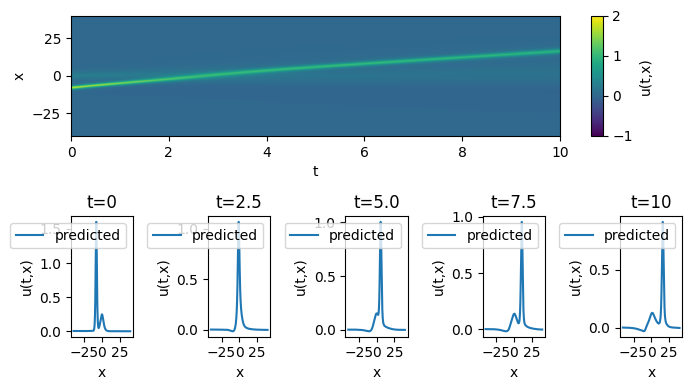

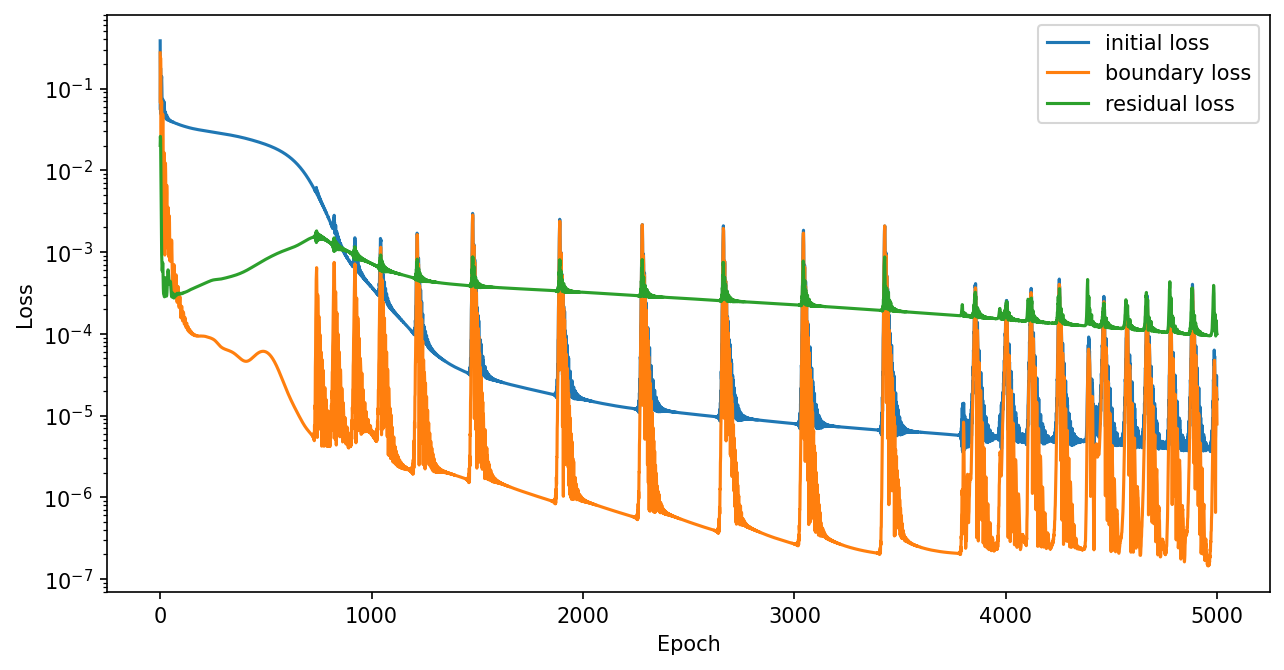

In [30]:
plot_kdv_model(model.network, x_start, length, time)

plot_training_loss(history, y_scale='log')

1/1 [==============================] - 0s 114ms/step


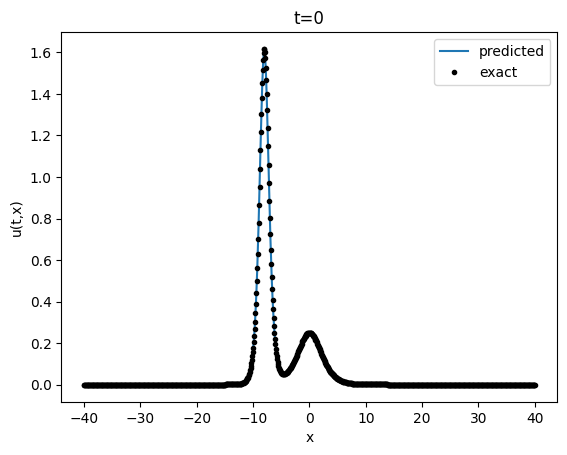

In [34]:
num_test_samples = 1000
t_flat = np.linspace(0, time, num_test_samples)
x_flat = np.linspace(x_start, length, num_test_samples)
t, x = np.meshgrid(t_flat, x_flat)
tx = np.stack([t.flatten(), x.flatten()], axis=-1)
t_cross_sections = [0] # put time here
for i, t_cs in enumerate(t_cross_sections):
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u = model.network.predict(tx, batch_size=num_test_samples)
    plt.plot(x_flat, u,label='predicted')
    u_exact = phi_function(tx)
    plt.plot(x_flat,u_exact,'k.',label='exact')
    plt.title('t={}'.format(np.round(t_cs,3)))
    plt.xlabel('x')
    plt.ylabel('u(t,x)')
    plt.legend(loc='upper right')
plt.show()

1/1 [==============================] - 0s 15ms/step


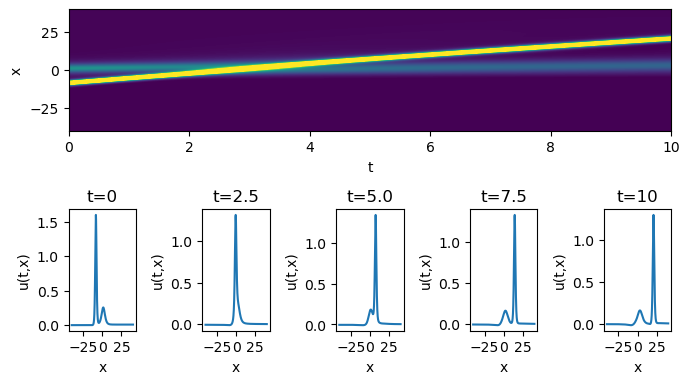

In [69]:
from Modules.models import LOSS_RESIDUAL, LOSS_BOUNDARY, LOSS_INITIAL, MEAN_ABSOLUTE_ERROR
from matplotlib.gridspec import GridSpec

def plot_kdv_model2(model,x_start, length, time, colorLim1 = -1, colorLim2 = 2,save_path = None) -> None:
    """
    Plot the model predictions for the heat equation.
    Args:
        model: A trained HeatPinn model.
        length: The length of the domain.
        time: The time frame of the simulation.
        save_path: The path to save the plot to.
    """
    num_test_samples = 2000
    t_flat = np.linspace(0, time, num_test_samples)
    x_flat = np.linspace(x_start, length, num_test_samples)
    t, x = np.meshgrid(t_flat, x_flat)
    tx = np.stack([t.flatten(), x.flatten()], axis=-1)
    u = model.predict(tx, batch_size=num_test_samples)
    u = u.reshape(t.shape)

    # plot u(t,x) distribution as a color-map
    fig = plt.figure(figsize=(7,4))
    gs = GridSpec(2, 5)
    plt.subplot(gs[0, :])
    plt.pcolormesh(t, x, u)
    plt.xlabel('t')
    plt.ylabel('x')
    cbar = plt.colorbar(pad=0.05, aspect=10)
    cbar.set_label('u(t,x)')
    cbar.mappable.set_clim(0, 0.5)
    cbar.remove() 
    # plot u(t=const, x) cross-sections
    t_cross_sections = [0, time/4, time/2, 3*time/4, time]
    for i, t_cs in enumerate(t_cross_sections):
        plt.subplot(gs[1, i])
        tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
        u = model.predict(tx, batch_size=num_test_samples)
        plt.plot(x_flat, u)
        plt.title('t={}'.format(np.round(t_cs,3)))
        plt.xlabel('x')
        plt.ylabel('u(t,x)')
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    
plot_kdv_model2(model.network, x_start, length, time)



# one soliton

In [44]:
k=6
c=5
phi = 0
def phi_function(tx):
    offset =  -3*np.pi
    #offset = 8
    return c / (2*tf.cosh(np.sqrt(c)*(tx[:, 1:2]-c*tx[:,0:1]+offset)/2)**2)+phi
    

def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])

x_start = 0
length = 8*np.pi
time =  np.pi/2

In [36]:
#(tx_samples, y_samples), (tx_init, y_init), (tx_boundary,y_boundary) = simulate_kdv(1000, f_init,boundary_function, x_start, length, time)
(tx_eqn, y_eqn), (tx_init, y_init), (tx_boundary, y_boundary) = simulate_kdv(2000, phi_function, boundary_function, length, time, x_start,random_seed = 42, dtype=tf.float32) 
network = KdvPinn.build_network([128, 128])
model = KdvPinn(network)
model.compile()


In [37]:
num = 200
t_flat = np.linspace(0, time, num)
x_flat = np.linspace(x_start, length, num)
t, x = np.meshgrid(t_flat, x_flat)

tx = np.stack([t.flatten(), x.flatten()], axis=-1)

# u = model.network.predict(tx, batch_size=num)
tx = tf.convert_to_tensor(tx)
soln = phi_function(tx)

In [38]:
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=1000, decay_rate=0.7)
inputs = tf.stack([tx_eqn, tx_init, tx_boundary], axis=0)
outputs = tf.stack([y_init, y_boundary], axis=0)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


In [39]:
history = model.fit(inputs, outputs, 10000, optimizer, progress_interval=200)
# 11,000

Epoch: 0 Loss: 1.2603 Total Elapsed Time: 6.66
Epoch: 200 Loss: 0.1994 Total Elapsed Time: 36.60
Epoch: 400 Loss: 0.1844 Total Elapsed Time: 67.99
Epoch: 600 Loss: 0.1502 Total Elapsed Time: 95.79
Epoch: 800 Loss: 0.1024 Total Elapsed Time: 128.28
Epoch: 1000 Loss: 0.0673 Total Elapsed Time: 160.92
Epoch: 1200 Loss: 0.0491 Total Elapsed Time: 187.37
Epoch: 1400 Loss: 0.0317 Total Elapsed Time: 222.63
Epoch: 1600 Loss: 0.0224 Total Elapsed Time: 245.20
Epoch: 1800 Loss: 0.0461 Total Elapsed Time: 267.31
Epoch: 2000 Loss: 0.0123 Total Elapsed Time: 288.93
Epoch: 2200 Loss: 0.0091 Total Elapsed Time: 310.90
Epoch: 2400 Loss: 0.0071 Total Elapsed Time: 333.88
Epoch: 2600 Loss: 0.0223 Total Elapsed Time: 355.92
Epoch: 2800 Loss: 0.0046 Total Elapsed Time: 378.62
Epoch: 3000 Loss: 0.0037 Total Elapsed Time: 401.22
Epoch: 3200 Loss: 0.0030 Total Elapsed Time: 423.38
Epoch: 3400 Loss: 0.0025 Total Elapsed Time: 446.28
Epoch: 3600 Loss: 0.0042 Total Elapsed Time: 468.27
Epoch: 3800 Loss: 0.0018

1/1 [==============================] - 0s 36ms/step


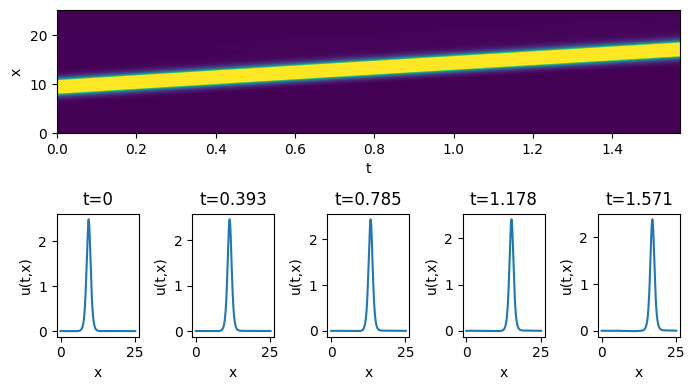

In [40]:
from Modules.models import LOSS_RESIDUAL, LOSS_BOUNDARY, LOSS_INITIAL, MEAN_ABSOLUTE_ERROR
from matplotlib.gridspec import GridSpec

def plot_kdv_model2(model,x_start, length, time, colorLim1 = -1, colorLim2 = 2,save_path = None) -> None:
    """
    Plot the model predictions for the heat equation.
    Args:
        model: A trained HeatPinn model.
        length: The length of the domain.
        time: The time frame of the simulation.
        save_path: The path to save the plot to.
    """
    num_test_samples = 2000
    t_flat = np.linspace(0, time, num_test_samples)
    x_flat = np.linspace(x_start, length, num_test_samples)
    t, x = np.meshgrid(t_flat, x_flat)
    tx = np.stack([t.flatten(), x.flatten()], axis=-1)
    u = model.predict(tx, batch_size=num_test_samples)
    u = u.reshape(t.shape)

    # plot u(t,x) distribution as a color-map
    fig = plt.figure(figsize=(7,4))
    gs = GridSpec(2, 5)
    plt.subplot(gs[0, :])
    plt.pcolormesh(t, x, u)
    plt.xlabel('t')
    plt.ylabel('x')
    cbar = plt.colorbar(pad=0.05, aspect=10)
    cbar.set_label('u(t,x)')
    cbar.mappable.set_clim(0, 0.5)
    cbar.remove() 
    # plot u(t=const, x) cross-sections
    t_cross_sections = [0, time/4, time/2, 3*time/4, time]
    for i, t_cs in enumerate(t_cross_sections):
        plt.subplot(gs[1, i])
        tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
        u = model.predict(tx, batch_size=num_test_samples)
        plt.plot(x_flat, u)
        plt.title('t={}'.format(np.round(t_cs,3)))
        plt.xlabel('x')
        plt.ylabel('u(t,x)')
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    
plot_kdv_model2(model.network, x_start, length, time)

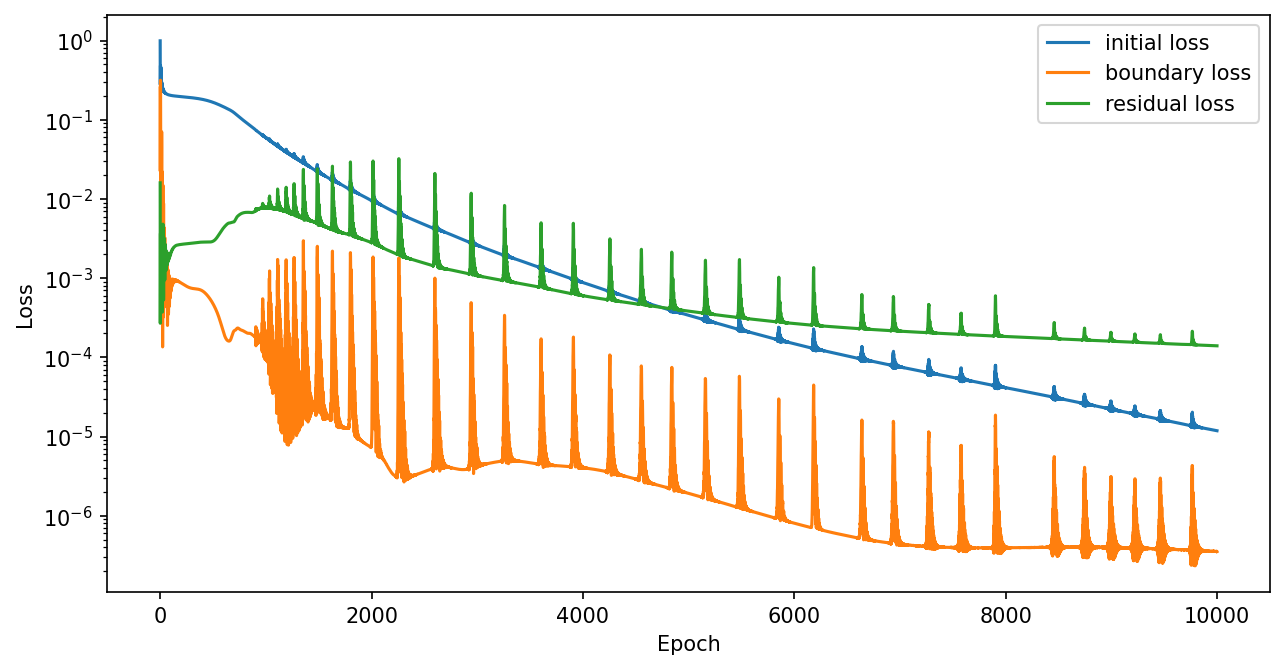

In [41]:
plot_training_loss(history, y_scale='log')


1/1 [==============================] - 0s 39ms/step


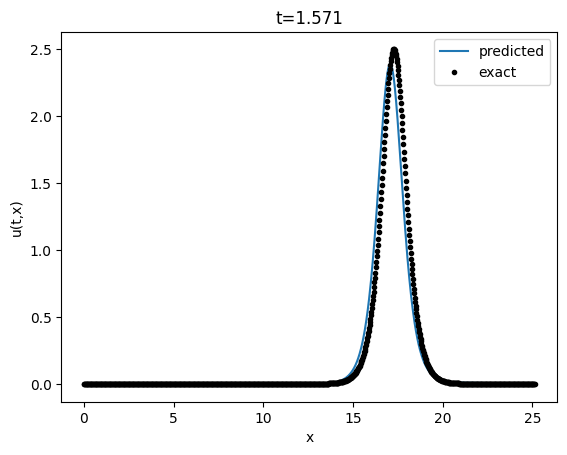

In [45]:
num_test_samples = 1000
t_flat = np.linspace(0, time, num_test_samples)
x_flat = np.linspace(x_start, length, num_test_samples)
t, x = np.meshgrid(t_flat, x_flat)
tx = np.stack([t.flatten(), x.flatten()], axis=-1)
t_cross_sections = [np.pi/2] # put time here
for i, t_cs in enumerate(t_cross_sections):
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u = model.network.predict(tx, batch_size=num_test_samples)
    plt.plot(x_flat, u,label='predicted')
    u_exact = phi_function(tx)
    plt.plot(x_flat,u_exact,'k.',label='exact')
    plt.title('t={}'.format(np.round(t_cs,3)))
    plt.xlabel('x')
    plt.ylabel('u(t,x)')
    plt.legend(loc='upper right')
plt.show()

# Finding the limit